# Imports

In [1]:
# Run Twice
import sys
sys.executable
!/opt/conda/bin/python -m pip install boto3 --user

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
pip install psycopg2

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Requires kernal restart
!pip install seaborn --upgrade --user

Requirement already up-to-date: seaborn in /home/ubuntu/.local/lib/python3.6/site-packages (0.11.2)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [4]:
# timedelta conversion
!pip install pytimeparse

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
import boto3
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
from s3_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from pytimeparse.timeparse import timeparse
import datetime as dt
import ast
sns.__version__

'0.11.2'

# S3 Buckets

In [6]:
# Define s3 bucket
bucket = 'fouryouandme-study-data'

#List s3 keys
# get_matching_s3_keys(bucket, prefix='bump/') #Remove prefix to view non-BUMP data

## Dataframe Imports

In [7]:
# Study IDs

key = 'bump/redcap/wave_2/study_ids.csv.gz'
df_studyID = pandas_from_csv_s3(bucket, key=key, compression='gzip')

In [8]:
# Birthing Data
key = 'bump/redcap/wave_2/birthing_data_cohort_2_only.csv.gz'
df_birth = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date

In [9]:
# Some dataframes use 'record_id' instead of 'user_id'. 
# You'll need to match it up with df_studyID where'evidation_id' is 'user_id'
# NOTE: Very few examples of this. Birthing data is the important one


df_birth = pd.merge(df_birth, df_studyID, on='record_id')
df_birth['user_id'] = df_birth.evidation_id

# There is a missing value in the birthing data. I'm removing it here
df_birth = df_birth.drop(index=50)


In [10]:
# Bodyport Wave 2
key = 'bump/bodyport/wave_2/bodyport.csv.gz'
df_bodyport = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# OPTIONAL: Convert date format
df_bodyport['date'] = pd.to_datetime(df_bodyport.event_date).dt.date 

In [11]:
# Garmin Wave 2
key = 'bump/garmin/wave_2/garmin_activities.csv.gz'
df_gAct = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_gAct['date'] = pd.to_datetime(df_gAct.event_date).dt.date

key = 'bump/garmin/wave_2/garmin_dailies.csv.gz'
df_gDaily = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_gDaily['date'] = pd.to_datetime(df_gDaily.event_date).dt.date

key = 'bump/garmin/wave_2/garmin_pulse_ox.csv.gz'
df_gPulse = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_gPulse['date'] = pd.to_datetime(df_gPulse.event_date).dt.date

key = 'bump/garmin/wave_2/garmin_respiration.csv.gz'
df_gResp = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_gResp['date'] = pd.to_datetime(df_gResp.event_date).dt.date

key = 'bump/garmin/wave_2/garmin_user_metrics.csv.gz'
df_gUser = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_gUser['date'] = pd.to_datetime(df_gUser.event_date).dt.date

In [12]:
# Oura Wave 2
key = 'bump/oura/wave_2/oura_sleep.csv.gz'
df_sleep = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

key = 'bump/oura/wave_2/oura_activity.csv.gz'
df_activity = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_activity['date'] = pd.to_datetime(df_activity.event_date).dt.date

key = 'bump/oura/wave_2/oura_readiness.csv.gz'
df_readiness = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_readiness['date'] = pd.to_datetime(df_readiness.event_date).dt.date

In [13]:
# Surveys Wave 2
key = 'bump/app_activities/wave_2/surveys.csv.gz'
df_survey = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_survey['date'] = pd.to_datetime(df_survey.updated_at).dt.date

key = 'bump/app_activities/wave_2/quick_activities.csv.gz'
df_sam = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date

In [14]:
# Daily Symptom Survey Questions (1-7 Likert Scale) (See Data Dictionary) 
nausea = df_survey[df_survey['question_id'] == 203]
fatigue = df_survey[df_survey['question_id'] == 204]
mood = df_survey[df_survey['question_id'] == 205]
breath = df_survey[df_survey['question_id'] == 206]
swollen = df_survey[df_survey['question_id'] == 207]
walk = df_survey[df_survey['question_id'] == 208]
remember = df_survey[df_survey['question_id'] == 209]

## Visualizations

In [15]:
# Plot metric over time
# Includes vertical yellow line if birthing data exists
#     Blue horizontal line is mean before birth
#     Red horizontal line is mean after birth
def exploreDataBirthBA(df, col, user_id):
    plt.rcParams.update({'figure.max_open_warning': 0})
    sns.set_theme(style='darkgrid')
    pdf = df.loc[df.user_id == user_id]

    
    plt.figure(figsize=(12,4))
    sns.scatterplot(data=pdf, x='date', y=col, ci=None, color='purple')
    sns.lineplot(data=pdf, x='date', y=col, ci=None)

    # Plot birthing data if it exists for that user
    if (len(df_birth.loc[df_birth.user_id == user_id]) != 0):
        birth = df_birth.loc[df_birth.user_id == user_id].reset_index()
        plt.axvline(x=birth.date, color = 'y', ls='--')
        ymin, ymax = plt.gca().get_ylim()
        xmin, xmax = plt.gca().get_xlim()
        plt.text(birth.date, ymax, birth['date'][0], fontsize=12, color='y')
        
        # Dataframe of data before birth
        after = pdf[~(pdf['date'] < birth.date[0])]
        before = pdf[~(pdf['date'] > birth.date[0])]
        before_avg = before[col].mean()
        after_avg = after[col].mean()
#         print('Pre-birth Average: ', before_avg)
#         print('Post-birth Average: ', after_avg)
        plt.hlines(y=before_avg, xmin=xmin, xmax=birth.date, color='blue', linestyles='dashdot')
        plt.hlines(y=after_avg, xmin=birth.date, xmax=xmax, color='red', linestyles='dashdot')
#         sns.lineplot(data=before, x='date', y=col, ci=None, color='r')
#         sns.lineplot(data=after, x='date', y=col, ci=None, color='r')

    plt.xlabel(''); plt.ylabel(col)
    plt.title('User ID: ' + str(user_id))
    plt.show

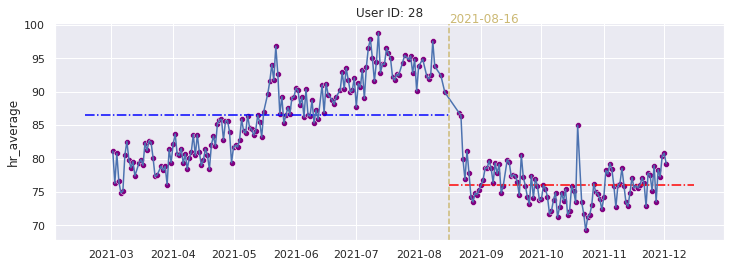

In [18]:
exploreDataBirthBA(df_sleep, 'hr_average', 28)

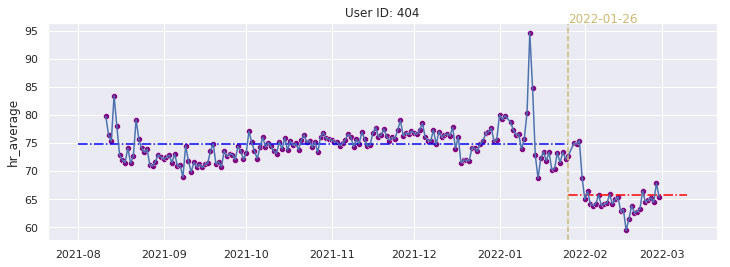

In [55]:
exploreDataBirthBA(df_sleep, 'hr_average', 404)

In [20]:
df_birth.user_id.unique()

array([  28.,   29.,   30., 1018.,   37.,   38.,   39.,   40.,   41.,
         42.,   44.,   45.,   47.,   53.,   54.,   55.,   61.,   62.,
         64.,   65.,   66.,   67.,   68.,   70.,   74., 1016.,   94.,
         95.,   99.,  101.,  118., 1365.,  135.,  137., 1014.,  158.,
        159., 1022.,  174.,  185.,  186.,  192.,  193.,  199.,  200.,
       1021.,  976.,  225., 1004.,  234.,  975.,  279.,  280.,  289.,
        290.,  293.,  404.,  405.,  406.,  407.,  408.,  410.,  977.,
       1047.,  428.,  429.,   nan,  980.,  594.,  595.,  596.,  599.,
        600.,  605.,  615.,  622., 1659.,  963.,  966.,  985.])

In [19]:
sleep_users_list = df_sleep.user_id.unique()
day_num_list = []
count = 0
for sleep_user in sleep_users_list:
    user_start_df = df_sleep.loc[df_sleep.user_id == sleep_user].sort_values(by="event_date")['event_date']
    user_birth_df = df_birth.loc[df_birth.user_id == sleep_user]['birth_date']
    if len(user_birth_df) > 0:
        start_date = user_start_df.iloc[0]
        birth_date = user_birth_df.iloc[0]
        start_date_object = dt.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
        birth_date_object = dt.datetime.strptime(birth_date, '%Y-%m-%d')
        day_num = (birth_date_object - start_date_object).days
        day_num_list.append(day_num)
        if day_num > 150:
            count += 1

(0.0, 20.0)

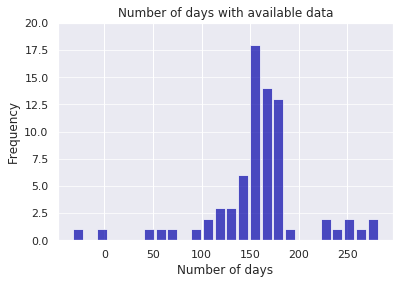

In [20]:
# the histogram of the data
n, bins, patches = plt.hist(x=day_num_list, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of days')
plt.ylabel('Frequency')
plt.title('Number of days with available data')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [26]:
SECONDS_PER_WEEK = 604800
SECONDS_PER_DAY = 86400


def convert_no_char_string_to_time_delta(val, delimiter):
    val_ls = val.split(delimiter)
    weeks = int(val_ls[0].strip())
    days = int(val_ls[1].strip())
    return weeks*SECONDS_PER_WEEK + days*SECONDS_PER_DAY

def convert_to_time_delta(val):
    res_seconds = 0
    if "w" not in val.lower() and "d" not in val.lower():
        # assume either "," or "." appears in string
        if "," in val.lower():
            res_seconds = convert_no_char_string_to_time_delta(val, ",")
        elif "." in val.lower():
            res_seconds = convert_no_char_string_to_time_delta(val, ".")
        elif " " in val.lower():
            res_seconds = convert_no_char_string_to_time_delta(val, " ")
        else:
          # integer week
          res_seconds = SECONDS_PER_WEEK*int(val.strip())
    else:
        res_seconds = timeparse(val)
    return dt.timedelta(seconds = res_seconds)

12 days, 0:00:00
12 days, 0:00:00
12 days, 0:00:00
12 days, 0:00:00
12 days, 0:00:00
7 days, 0:00:00


In [31]:
df_birth.loc[df_birth.user_id == 135]['birth_gestage']

32    3,2
Name: birth_gestage, dtype: object

In [61]:
count_gestage = 0
df_birth['conception_time'] = np.nan
for user in sleep_users_list:
    gestage = df_birth.loc[df_birth.user_id == user]['birth_gestage']
    user_birth_df = df_birth.loc[df_birth.user_id == user]['birth_date']
    gestage = gestage[~gestage.isnull()]
    if len(gestage) > 0:
        user_birth = dt.datetime.strptime(user_birth_df.iloc[0], '%Y-%m-%d')
        gestage_timedelta = convert_to_time_delta(gestage.iloc[0])
        if gestage_timedelta > dt.timedelta(weeks=30):
            count_gestage += 1
            conception_time = user_birth - gestage_timedelta + dt.timedelta(weeks=2)
            df_birth.at[gestage.index, 'conception_time'] = conception_time
#             print(f'user id: {user}')
#             print(gestage.iloc[0])
#             print(user_birth)
#             print(user_birth - gestage_timedelta + dt.timedelta(weeks=2))
#             print('-------------------------------------')
print(f'{count_gestage} people have reasonable birth_date and birth_gestage.')


66 people have reasonable birth_date and birth_gestage.


In [62]:
dt.datetime.strptime('1999-02-19', '%Y-%m-%d') < dt.datetime.strptime('1998-06-28', '%Y-%m-%d')

False

In [94]:
sleep_users_list = df_sleep.user_id.unique()
day_num_list = []
available_trimester_count = 0
for sleep_user in sleep_users_list:
    user_start_df = df_sleep.loc[df_sleep.user_id == sleep_user].sort_values(by="event_date")['event_date']
    user_conception_df = df_birth.loc[df_birth.user_id == sleep_user]['conception_time']
    user_conception_df = user_conception_df[~user_conception_df.isnull()]
#     print(user_start_df)
    if len(user_conception_df) > 0:
        conception_date = user_conception_df.iloc[0]
        trimester_start = conception_date + dt.timedelta(weeks=22)
        trimester_end = conception_date + dt.timedelta(weeks=26)
        start_date = user_start_df.iloc[0]
        end_date = user_start_df.iloc[-1]
        start_date_object = dt.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
        end_date_object = dt.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
        if start_date_object <= trimester_start and end_date_object >= trimester_end:
            available_trimester_count += 1
print(available_trimester_count)

60


In [89]:
user_id_list = df_sleep.user_id.unique()
user_id_list.sort()

In [90]:
len(user_id_list)

266

In [22]:
cols = [
    "user_id",
    "hr_average",
    "score",
    "temperature_delta",
    "date",
    "peripheral_fluid",
    "weight_kg"
]
# univariant time series problem
# z score normalization
# df_sleep
# df_bodyport
# df_oura

In [44]:
def get_user(user_id, state, end):
    user_sleep = df_sleep[df_sleep.user_id == user_id].dropna()
    user_bp = df_bodyport[df_bodyport.user_id == user_id].dropna()
    user_walk = walk[walk.user_id == user_id].dropna()
    user_walk = user_walk[["answer_text", "date"]].rename(columns={"answer_text" : "walk"})
    user_walk["walk"] = user_walk["walk"].astype(int)
    user_fatigue = fatigue[fatigue.user_id == user_id].dropna()[["answer_text", "date"]].rename(columns={"answer_text" : "fatigue"})
    user_fatigue["fatigue"] = user_fatigue["fatigue"].astype(int)
    df2 = pd.merge(user_sleep, user_bp, on="date")
    df2 = pd.merge(df2, user_fatigue, on="date", how="outer")
    df2 = pd.merge(df2, user_walk, on="date", how="outer")
    df2.set_index(df2["date"], inplace=True)
    df2.sort_index(inplace=True)
    mask = pd.to_datetime(df2["date"]).between(start.astype(str)[0], end.astype(str)[0], inclusive=True)
    user_df = df2[mask]
    return user_df
from datetime import timedelta
users = []
births = []
for user_id in df_sleep.user_id.unique():
    birth = df_birth.loc[df_birth.user_id == user_id].reset_index()
    birthdate = birth["date"]
    if len(birth) > 0:
        start = birthdate - pd.to_timedelta(300, unit='d') # pd.to_timedelta(100, unit='d')
        end = birthdate + pd.to_timedelta(0, unit='d')
        date_range = pd.date_range(start[0], end[0]-timedelta(days=1), freq='d')
        df = get_user(user_id, start, end)
        dr = pd.DataFrame()
        dr["d"] = date_range.date
        dr.set_index(dr.d, inplace=True)
        df = dr.join(df)
        if len(df) > 20: # If person has 20 measurements at least
            df.set_index(df.d - df.d.min(), inplace=True)
            df = df.resample("D").mean()
            df.set_index(df.index.days, inplace=True)
            df = df.interpolate("linear", 0)
            users.append(df.fillna(df.mean(0)))
            births.append(birth)

In [45]:
len(users)

74

In [34]:
!pip install ruptures --upgrade --user

     |████████████████████████████████| 995 kB 28.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [35]:
import matplotlib.pyplot as plt
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

AttributeError: module 'numpy.random' has no attribute 'default_rng'